# Sensor Fusion Using Synthetic Radar and Vision Data

This example shows how to generate a scenario, simulate sensor detections, and use sensor fusion to track simulated vehicles. The main benefit of using scenario generation and sensor simulation over sensor recording is the ability to create rare and potentially dangerous events and test the vehicle algorithms with them. This example covers the entire synthetic data workflow.

## Generate the Scenario

Scenario generation comprises generating a road network, defining vehicles that move on the roads, and moving the vehicles.

In this example, you test the ability of the sensor fusion to track a vehicle that is passing on the left of the ego vehicle. The scenario simulates a highway setting, and additional vehicles are in front of and behind the ego vehicle.

Add a stretch of 500 meters of typical highway road with two lanes. The road is defined using a set of points, where each point defines the center of the road in 3-D space, and a road width.

Create the ego vehicle and three cars around it: one that overtakes the ego vehicle and passes it on the left, one that drives right in front of the ego vehicle and one that drives right behind the ego vehicle. All the cars follow the path defined by the road waypoints by using the path driving policy. The passing car will start on the right lane, move to the left lane to pass, and return to the right lane.

In [1]:
% Define an empty scenario
scenario = drivingScenario;
scenario.SampleTime = 0.01;

roadCenters = [0 0; 50 0; 100 0; 250 20; 500 40];
roadWidth = 7.2; % Two lanes, each 3.6 meters
road(scenario, roadCenters, roadWidth);

% Create the ego vehicle that travels at 25 m/s along the road
egoCar = vehicle(scenario, 'ClassID', 1);
path(egoCar, roadCenters(2:end,:) - [0 1.8], 25); % On right lane

% Add a car in front of the ego vehicle
leadCar = vehicle(scenario, 'ClassID', 1);
path(leadCar, [70 0; roadCenters(3:end,:)] - [0 1.8], 25); % On right lane

% Add a car that travels at 35 m/s along the road and passes the ego vehicle
passingCar = vehicle(scenario, 'ClassID', 1);
waypoints = [0 -1.8; 50 1.8; 100 1.8; 250 21.8; 400 32.2; 500 38.2];
path(passingCar, waypoints, 35);

% Add a car behind the ego vehicle
chaseCar = vehicle(scenario, 'ClassID', 1);
path(chaseCar, [25 0; roadCenters(2:end,:)] - [0 1.8], 25); % On right lane

## Define Radar and Vision Sensors

In this example, you simulate an ego vehicle that has 6 radar sensors and 2 vision sensors covering the 360 degrees field of view. The sensors have some overlap and some coverage gap. The ego vehicle is equipped with a long-range radar sensor and a vision sensor on both the front and the back of the vehicle. Each side of the vehicle has two short-range radar sensors, each covering 90 degrees. One sensor on each side covers from the middle of the vehicle to the back. The other sensor on each side covers from the middle of the vehicle forward. The figure in the next section shows the coverage.

In [2]:
sensors = cell(8,1);
% Front-facing long-range radar sensor at the center of the front bumper of the car.
sensors{1} = radarDetectionGenerator('SensorIndex', 1, 'Height', 0.2, 'MaxRange', 174, ...
    'SensorLocation', [egoCar.Wheelbase + egoCar.FrontOverhang, 0], 'FieldOfView', [20, 5]);

% Rear-facing long-range radar sensor at the center of the rear bumper of the car.
sensors{2} = radarDetectionGenerator('SensorIndex', 2, 'Height', 0.2, 'Yaw', 180, ...
    'SensorLocation', [-egoCar.RearOverhang, 0], 'MaxRange', 174, 'FieldOfView', [20, 5]);

% Rear-left-facing short-range radar sensor at the left rear wheel well of the car.
sensors{3} = radarDetectionGenerator('SensorIndex', 3, 'Height', 0.2, 'Yaw', 120, ...
    'SensorLocation', [0, egoCar.Width/2], 'MaxRange', 30, 'ReferenceRange', 50, ...
    'FieldOfView', [90, 5], 'AzimuthResolution', 10, 'RangeResolution', 1.25);

% Rear-right-facing short-range radar sensor at the right rear wheel well of the car.
sensors{4} = radarDetectionGenerator('SensorIndex', 4, 'Height', 0.2, 'Yaw', -120, ...
    'SensorLocation', [0, -egoCar.Width/2], 'MaxRange', 30, 'ReferenceRange', 50, ...
    'FieldOfView', [90, 5], 'AzimuthResolution', 10, 'RangeResolution', 1.25);

% Front-left-facing short-range radar sensor at the left front wheel well of the car.
sensors{5} = radarDetectionGenerator('SensorIndex', 5, 'Height', 0.2, 'Yaw', 60, ...
    'SensorLocation', [egoCar.Wheelbase, egoCar.Width/2], 'MaxRange', 30, ...
    'ReferenceRange', 50, 'FieldOfView', [90, 5], 'AzimuthResolution', 10, ...
    'RangeResolution', 1.25);

% Front-right-facing short-range radar sensor at the right front wheel well of the car.
sensors{6} = radarDetectionGenerator('SensorIndex', 6, 'Height', 0.2, 'Yaw', -60, ...
    'SensorLocation', [egoCar.Wheelbase, -egoCar.Width/2], 'MaxRange', 30, ...
    'ReferenceRange', 50, 'FieldOfView', [90, 5], 'AzimuthResolution', 10, ...
    'RangeResolution', 1.25);

% Front-facing camera located at front windshield.
sensors{7} = visionDetectionGenerator('SensorIndex', 7, 'FalsePositivesPerImage', 0.1, ...
    'SensorLocation', [0.75*egoCar.Wheelbase 0], 'Height', 1.1);

% Rear-facing camera located at rear windshield.
sensors{8} = visionDetectionGenerator('SensorIndex', 8, 'FalsePositivesPerImage', 0.1, ...
    'SensorLocation', [0.2*egoCar.Wheelbase 0], 'Height', 1.1, 'Yaw', 180);


## Create a Tracker

Create a multiObjectTracker to track the vehicles that are close to the ego vehicle. The tracker uses the initSimDemoFilter supporting function to initialize a constant velocity linear Kalman filter that works with position and velocity.

Tracking is done in 2-D. Although the sensors return measurements in 3-D, the motion itself is confined to the horizontal plane, so there is no need to track the height.

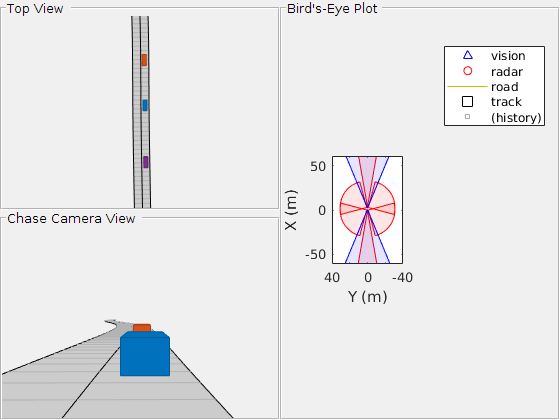

In [3]:
tracker = multiObjectTracker('FilterInitializationFcn', @initSimDemoFilter, ...
    'AssignmentThreshold', 30, 'ConfirmationParameters', [4 5]);
positionSelector = [1 0 0 0; 0 0 1 0]; % Position selector
velocitySelector = [0 1 0 0; 0 0 0 1]; % Velocity selector

% Create the display and return a handle to the bird's-eye plot
BEP = createDemoDisplay(egoCar, sensors);

## Simulate the Scenario

The following loop moves the vehicles, calls the sensor simulation, and performs the tracking.

Note that the scenario generation and sensor simulation can have different time steps. Specifying different time steps for the scenario and the sensors enables you to decouple the scenario simulation from the sensor simulation. This is useful for modeling actor motion with high accuracy independently from the sensor's measurement rate.

Another example is when the sensors have different update rates. Suppose one sensor provides updates every 20 milliseconds and another sensor provides updates every 50 milliseconds. You can specify the scenario with an update rate of 10 milliseconds and the sensors will provide their updates at the correct time.

In this example, the scenario generation has a time step of 0.01 second, while the sensors detect every 0.1 second. The sensors return a logical flag, isValidTime, that is true if the sensors generated detections. This flag is used to call the tracker only when there are detections.

Another important note is that the sensors can simulate multiple detections per target, in particular when the targets are very close to the radar sensors. Because the tracker assumes a single detection per target from each sensor, you must cluster the detections before the tracker processes them. This is done by the function clusterDetections. See the 'Supporting Functions' section.

In [4]:
toSnap = true;
while advance(scenario) && ishghandle(BEP.Parent)
    % Get the scenario time
    time = scenario.SimulationTime;

    % Get the position of the other vehicle in ego vehicle coordinates
    ta = targetPoses(egoCar);

    % Simulate the sensors
    detections = {};
    isValidTime = false(1,8);
    for i = 1:8
        [sensorDets,numValidDets,isValidTime(i)] = sensors{i}(ta, time);
        if numValidDets
            for j = 1:numValidDets
                % Vision detections do not report SNR. The tracker requires
                % that they have the same object attributes as the radar
                % detections. This adds the SNR object attribute to vision
                % detections and sets it to a NaN.
                if ~isfield(sensorDets{j}.ObjectAttributes{1}, 'SNR')
                    sensorDets{j}.ObjectAttributes{1}.SNR = NaN;
                end
            end
            detections = [detections; sensorDets]; %#ok<AGROW>
        end
    end

    % Update the tracker if there are new detections
    if any(isValidTime)
        vehicleLength = sensors{1}.ActorProfiles.Length;
        detectionClusters = clusterDetections(detections, vehicleLength);
        confirmedTracks = updateTracks(tracker, detectionClusters, time);

        % Update bird's-eye plot
        updateBEP(BEP, egoCar, detections, confirmedTracks, positionSelector, velocitySelector);
    end

    % Snap a figure for the document when the car passes the ego vehicle
    if ta(1).Position(1) > 0 && toSnap
        toSnap = false;
        snapnow
    end
end

## Summary

This example shows how to generate a scenario, simulate sensor detections, and use these detections to track moving vehicles around the ego vehicle.

You can try to modify the scenario road, or add or remove vehicles. You can also try to add, remove, or modify the sensors on the ego vehicle, or modify the tracker parameters.